In [1]:
from PIL import Image
import os
os.environ["THEANO_FLAGS"] = "device=gpu2, floatX=float32" # 
import pickle
from net_functions import *
from retrainGaussian import gaussian2
import copy
import matplotlib.pyplot as plt

import MyConfig


%load_ext autoreload
%autoreload 2

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 2: GeForce GTX TITAN Z (CNMeM is disabled, cuDNN 5110)


In [19]:
class testGaussian(gaussian2):
    def __init__(self):
        gaussian2.__init__(self)
        self.testImgsPath = MyConfig.testImgPath

    def load_xbatch(self, local_training_set_indices, imgList, trainImgsPath):
        rgb_list = []
        for idx in local_training_set_indices:
            rgb = np.asarray(Image.open(trainImgsPath+imgList[idx]))[:, :, 0:3]

            H, W = np.shape(rgb)[0:2]
            rgb_theano = rgb.transpose((2, 0, 1))
            rgb_theano = rgb_theano.reshape((1, 3, H, W))
            rgb_list.append(rgb_theano)

        x_in = np.concatenate(rgb_list,axis = 0 )
        return x_in
    
    def run_test(self, em, fileExt):
        #load parameters
        self.loadImgList(self.testImgsPath, fileExt)
        print 'load ', MyConfig.bgParams_path
        params_bg = pickle.load(open(MyConfig.bgParams_path))
        self.mBGsub.setParams(params_bg)
        print 'load ', MyConfig.net_params_path+'EM%d_params_regression.pickle' % (em)
        params_regression = pickle.load(open( MyConfig.net_params_path+'EM%d_params_regression.pickle' % (em)))
        self.regression_net.load_regression_params(params_regression)
        gaussian_params = pickle.load(open(MyConfig.net_params_path+'EM%d_params_gaussian.pickle' % (em)))
        load_gaussian_params(self.params_gaussian, gaussian_params)

        #load data
        test_size = 3
        generated_testing_set_order = np.random.permutation( np.arange(0, len(self.imgList)) )
        
        x_in = self.load_xbatch(generated_testing_set_order[:test_size], self.imgList, self.testImgsPath)
        fg_p,all_p,g_params = self.run_function(x_in)
        return fg_p, all_p, g_params, x_in
    

In [20]:
g_test = testGaussian()

initial gaussian sum
in update_sum n = 8


In [21]:
fg_p, parts_p, gaus_param, x_in= g_test.run_test(0, MyConfig.imgExt)

load  ./VGG/models/paramsBG.pickle
load  ./Potentials/Parts/log_GMM/net/EM0_params_regression.pickle


In [22]:
CNN_factor = 4
def showPartsResult(fg_p, parts_p, x_in, method='max'):
    for idx in range(parts_p.shape[0]):
        fg_np = np.asarray(fg_p[idx]).transpose(1, 2, 0)
        fg_np_resize = fg_np.repeat(CNN_factor, axis=0).repeat(CNN_factor, axis=1)
        img = copy.copy(x_in[idx].transpose((1, 2, 0)))
        H_re, W_re = fg_np_resize.shape[0:2]  # should only correspond to the small crop on the side
        print 'fg'
        img[0:H_re, 0:W_re, 1] = img[0:H_re, 0:W_re, 1] * 0.5
        img[0:H_re, 0:W_re, 2] = img[0:H_re, 0:W_re, 2] * 0.5
        img[0:H_re, 0:W_re, 0] = img[0:H_re, 0:W_re, 0] * 0.5 + (fg_np_resize[:, :, 0] > 0.6) * 120
        plt.imshow(img)
        plt.show()

        p_np = np.asarray(parts_p[idx]).transpose(1, 2, 0)
        p_np_resize = p_np.repeat(CNN_factor, axis=0).repeat(CNN_factor, axis=1)
        H_re, W_re, class_num = p_np_resize.shape
        img = copy.copy(x_in[idx].transpose((1, 2, 0)))
        p_np = np.asarray(parts_p[idx]).transpose(1, 2, 0)
        class_num = p_np.shape[2]

        fg_np1 = fg_np[:,:,0]
        fg_np_resize = fg_np1.repeat(CNN_factor, axis=0).repeat(CNN_factor, axis=1)

        maxClass = np.argmax(p_np, axis=2)
        maxC_resize = maxClass.repeat(CNN_factor, axis=0).repeat(CNN_factor, axis=1)
        H_re, W_re= maxC_resize.shape

        img = copy.copy(x_in[idx].transpose((1, 2, 0)))
        #show 3 classes in one image
        for i in range(0, class_num):
            print 'class', i
            img[0:H_re, 0:W_re, i%3] = img[0:H_re, 0:W_re, i%3] * 0.5 + (maxC_resize[:,:] == i) * 120 * fg_np_resize
            if i%3 == 2 or i==class_num-1:
                if i%3 ==0 :
                    img[0:H_re, 0:W_re, 1] = img[0:H_re, 0:W_re, 1] * 0.5
                    img[0:H_re, 0:W_re, 2] = img[0:H_re, 0:W_re, 2] * 0.5
                elif i%3 ==1:
                    img[0:H_re, 0:W_re, 2] = img[0:H_re, 0:W_re, 2] * 0.5
                img = img[0:H_re, 0:W_re, :]
                plt.imshow(img)
                plt.axis('off')
                plt.show()
                img = copy.copy(x_in[idx].transpose((1, 2, 0)))

                

fg


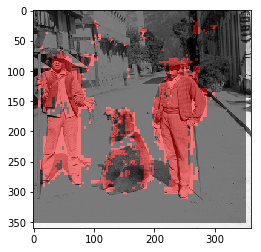

class 0
class 1
class 2


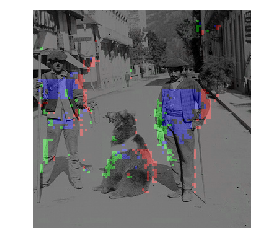

class 3
class 4
class 5


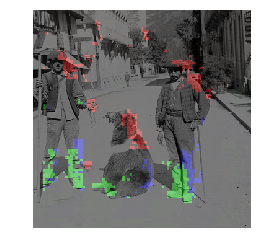

class 6
class 7


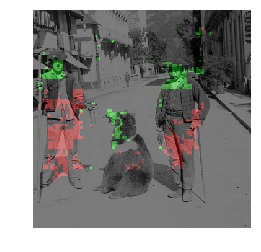

fg


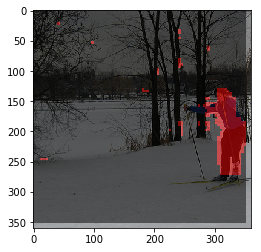

class 0
class 1
class 2


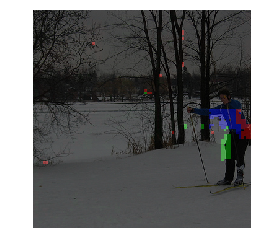

class 3
class 4
class 5


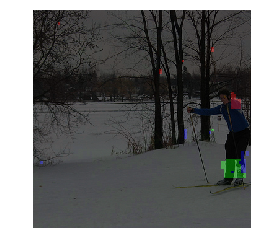

class 6
class 7


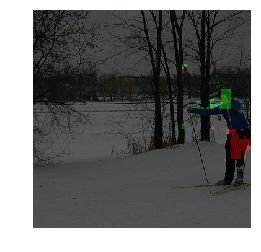

fg


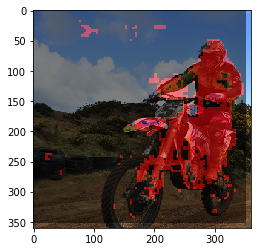

class 0
class 1
class 2


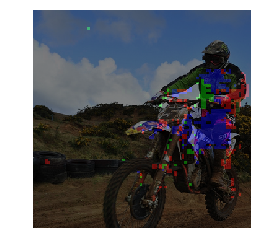

class 3
class 4
class 5


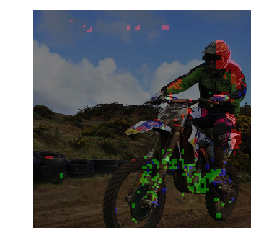

class 6
class 7


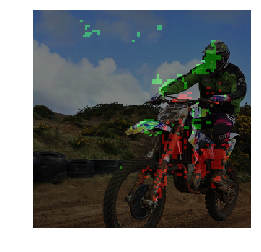

In [23]:
showPartsResult(fg_p, parts_p, x_in, method='max')